In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.max_columns',100)

DATA_PATH = '../okko/orig_data'
PREPARED_PATH = './prepared_data/'

In [3]:
def get_recomend(model,X,fe,test_users,user_history_films,user_features = None,item_features = None,mode = 'lightfm',N = 20,is_filter_history = True):
    # Сделаем какой-нибудь сабмит из lightfm
    result = {}
    #'implicit'#'lightfm'
    cnt = 0
    for user_uid in tqdm.tqdm(test_users):

        # transform user_uid to model's internal user category
        try:
            user_cat = fe.match_user_row[user_uid]
        except LookupError:
            continue
        
        if mode == 'lightfm':
            if is_filter_history:
                need_cols = np.array(list(set(np.arange(X.shape[1])) - user_history_films.get(user_cat, set())))
            else:
                need_cols = np.array(list(set(np.arange(X.shape[1]))))
            recs = model.predict(user_cat,need_cols,item_features=item_features,user_features=user_features)
            need_movies = np.argsort(-recs)[:N]
            result[user_uid] = [int(fe.train_movie_match_row_movie[i]) for i in need_movies]
            
                
        # переводим в фильмы

        # perform inference
        if mode == 'implicit':
            if cnt == 0:
                ratings_matrix_T = X.tocsr()
            if is_filter_history:
                recs = model.recommend(
                    user_cat,
                    X.tocsr(),
                    N=N,
                    filter_already_liked_items=True,
                    filter_items=user_history_films.get(user_uid, set())
                )
            else:
                recs = model.recommend(
                    user_cat,
                    X.tocsr(),
                    N=N,filter_already_liked_items=False,
                )
            result[user_uid] = [int(fe.train_movie_match_row_movie[i]) for i, _ in recs]
            # drop scores and transform model's internal elelemnt category to element_uid for every prediction
        # also convert np.uint64 to int so it could be json serialized later
        cnt += 1
    return result

def get_predict (model,X,fe,test_users,user_history_films,user_features = None,item_features = None,mode = 'lightfm',):
    # Сделаем какой-нибудь сабмит из lightfm
    result = {}
    #'implicit'#'lightfm'
    cnt = 0
    for user_uid in tqdm.tqdm(test_users):

        # transform user_uid to model's internal user category
        try:
            user_cat = fe.match_user_row[user_uid]
        except LookupError:
            continue
        
        if mode == 'lightfm':
#             if is_filter_history:
#                 need_cols = np.array(list(set(np.arange(X.shape[1])) - user_history_films.get(user_cat, set())))
#             else:
            need_cols = np.array(list(set(np.arange(X.shape[1]))))
            recs = model.predict(user_cat,need_cols,item_features=item_features,user_features=user_features)
            #need_movies = np.argsort(-recs)[:N]
            result[user_uid] = recs#[int(fe.train_movie_match_row_movie[i]) for i in need_movies]
            
                
        # переводим в фильмы

        # perform inference
        if mode == 'implicit':
            if cnt == 0:
                ratings_matrix_T = X.tocsr()
            
            recs = model.rank_items(user_cat, X.tocsr(), np.arange(X.shape[1]), )
            recs = sorted(recs,key = lambda x:x[0])
            
            result[user_uid] = [score for i, score in recs]
            # drop scores and transform model's internal elelemnt category to element_uid for every prediction
        # also convert np.uint64 to int so it could be json serialized later
            cnt += 1
    return result

In [4]:
data = pd.read_pickle(PREPARED_PATH+'some_wm.pkl')

In [5]:
data.head(40)

rel_dur  type  rating action_enc cons_enc  \
user_uid element_uid                                               
0        6127         0.107821   1.0     NaN      watch        S   
         8168         0.025000   1.0     NaN      watch        S   
         1284         0.022222   1.0     NaN      watch        S   
         1535         0.015385   1.0     NaN      watch        S   
         460          0.033333   1.0     NaN      watch        S   
         7190         0.946515   1.0     NaN      watch        S   
         8183         0.360333   1.0     NaN      watch        S   
         1983         0.858571   1.0     NaN      watch        S   
         6272         0.841667   1.0     NaN      watch        S   
         1016         1.020000   1.0     NaN      watch        S   
         1165         0.510000   1.0     NaN      watch        S   
         5035         0.957037   1.0     NaN      watch        S   
         434          0.893030   1.0     NaN      watch        S   
         6961         1.001042   1.0     NaN      watch        S   
         10150        0.985556   1.0     NaN      watch        S   
         3651         1.222000   1.0     NaN      watch        S   
         2081         0.802222   1.0     NaN      watch        S   
         2429         0.001436   3.0     NaN      watch        S   
         4290         0.425417   1.0     NaN      watch        S   
         2570         0.890185   1.0     NaN      watch        S   
         2143         0.801833   1.0     NaN      watch        S   
         4972         0.000000   1.0     NaN      watch        S   
         944          0.067037   1.0     NaN      watch        S   
         5366         1.453333   1.0     NaN      watch        S   
         2651         0.918333   1.0     NaN      watch        S   
         3567         0.861500   1.0     NaN      watch        S   
         5039         0.512037   1.0     NaN      watch        S   
         3722         0.961500   1.0     NaN      watch        S   
         9175         0.250833   1.0     NaN      watch        S   
         3496         0.200417   1.0     NaN      watch        S   
         3029         1.026458   1.0     NaN      watch        S   
         8747         1.292593   1.0     NaN      watch        S   
         7869         0.928939   1.0     NaN      watch        S   
         2639         0.015476   1.0     NaN      watch        S   
         1550         0.741333   1.0     NaN      watch        S   
         7498         0.281000   1.0     NaN      watch        S   
         2382         0.968194   1.0     NaN      watch        S   
         4935         0.962000   1.0     NaN      watch        S   
         2487         0.980000   1.0     NaN      watch        S   
         7179         0.916190   1.0     NaN      watch        S   

                          first_ts    first_ts_1       diff_ts  duration  \
user_uid element_uid                                                       
0        6127         4.332506e+07           NaN  12339.563912       130   
         8168         4.333740e+07  4.332506e+07     35.834058        80   
         1284         4.333743e+07  4.333740e+07     33.798077        90   
         1535         4.333747e+07  4.333743e+07     30.798518       130   
         460          4.333750e+07  4.333747e+07    120.224309       120   
         7190         4.333762e+07  4.333750e+07   1252.552669       110   
         8183         4.333887e+07  4.333762e+07  15727.796149       100   
         1983         4.335460e+07  4.333887e+07  10453.541197       140   
         6272         4.336505e+07  4.335460e+07    908.506874       100   
         1016         4.336596e+07  4.336505e+07  14180.229511       110   
         1165         4.338014e+07  4.336596e+07     55.607472       110   
         5035         4.338020e+07  4.338014e+07    893.051582        90   
         434          4.338109e+07  4.338020e+07  12655.099645       110   
         6961         4.33

In [6]:
data_catalogue = pd.read_pickle(PREPARED_PATH+'data_catalogue.pkl')
with open(PREPARED_PATH+'catalogue_features.pkl','rb') as f:
    match_element_row,match_row_element,match_columns,element_matrix = pickle.load(f)

In [7]:
# Получили фичи для фильмов
import pickle
with open(PREPARED_PATH+'catalogue_features.pkl','rb') as f:
    match_element_row,match_row_element,match_columns,element_matrix = pickle.load(f)
movie_match_columns = {i:ii for ii,i in enumerate(match_columns)}
movie_columns_match = {ii:i for ii,i in enumerate(match_columns)}

with open(PREPARED_PATH+'bag_of_attr_movie.pkl','rb') as f:
    bag_of_attr = pickle.load(f)

In [8]:
# Попробуем честно прорешать задачу классификации для оценок, чтобы восстановить зависимости
import lightgbm
import xgboost
import catboost

In [9]:
data_class = data.loc[~data['rating'].isnull()]

In [10]:
data_class.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 438790 entries, (1, 1653) to (593486, 7233)
Data columns (total 25 columns):
rel_dur              438790 non-null float64
type                 438790 non-null float64
rating               438790 non-null float64
action_enc           438790 non-null object
cons_enc             357343 non-null object
first_ts             438790 non-null float64
first_ts_1           438790 non-null float64
diff_ts              424176 non-null float64
duration             438790 non-null int64
feature_1            438790 non-null float64
feature_2            438790 non-null float64
feature_3            438790 non-null int64
feature_4            438790 non-null float64
feature_5            438790 non-null float64
is_history           438790 non-null int32
is_future            438790 non-null int32
diff_novice_ts       438790 non-null float64
target               438790 non-null int32
mean_rating_user     438790 non-null float64
num_watched_user     438790 no

In [11]:
y = data_class['rating'].astype(int)

In [12]:
data.action_enc.value_counts()

watch                  9047668
bookmate                678865
watch+rate              330622
watch+bookmate          238001
rate                     76818
watch+rate+bookmate      26721
rate+bookmate             4629
Name: action_enc, dtype: int64

In [13]:
need_cols = ['rel_dur','type','action_enc','cons_enc','diff_ts','feature_1','feature_2','feature_3','feature_4','feature_5',
            'is_history','diff_novice_ts','probably_kp_rate','num_watched_movie']
#'mean_rating_user','mean_target_movie',
data_cut = data_class[need_cols]
data_cut['action_enc'] = data_cut['action_enc'].map({'watch':1,'bookmate':2,'watch+rate':3,'watch+bookmate':4,
                                                    'rate':5,'watch+rate+bookmate':6,'rate+bookmate':7})
data_cut['cons_enc'] = data_cut['cons_enc'].map({'S':1,'P':2,'R':3,})

C:\Users\yabom\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\yabom\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [14]:
lgb_dataset = lightgbm.Dataset(data_cut,y,categorical_feature=['feature_3','type','action_enc','cons_enc','is_history'],
                              free_raw_data=False)

In [15]:
from sklearn.metrics import roc_auc_score,accuracy_score

In [16]:
def binary_error(preds, train_data):
    labels = train_data.get_label()
    lab = pd.get_dummies(labels)
    return 'roc_error', roc_auc_score(lab,preds.reshape((-1,11))) , True


In [17]:
params = {
    'objective':'softmax',
    'num_class':11,
    'boosting':'dart',
    #'metric':['multi_error'],
}
p = lightgbm.cv(params,lgb_dataset,num_boost_round=10000,early_stopping_rounds=20,verbose_eval=True,feval = binary_error)

C:\Users\yabom\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	cv_agg's multi_logloss: 2.30092 + 0.00016112	cv_agg's roc_error: 0.499513 + 0.000817307
[2]	cv_agg's multi_logloss: 2.22518 + 0.000187772	cv_agg's roc_error: 0.499577 + 0.000979328
[3]	cv_agg's multi_logloss: 2.16312 + 0.000246754	cv_agg's roc_error: 0.499641 + 0.000957761
[4]	cv_agg's multi_logloss: 2.11088 + 0.00032173	cv_agg's roc_error: 0.499562 + 0.00104792
[5]	cv_agg's multi_logloss: 2.06614 + 0.000365501	cv_agg's roc_error: 0.49957 + 0.00105049
[6]	cv_agg's multi_logloss: 2.02722 + 0.000390226	cv_agg's roc_error: 0.499508 + 0.00107242
[7]	cv_agg's multi_logloss: 1.99311 + 0.00046965	cv_agg's roc_error: 0.499502 + 0.00107765
[8]	cv_agg's multi_logloss: 2.01086 + 0.000437135	cv_agg's roc_error: 0.499501 + 0.00106637
[9]	cv_agg's multi_logloss: 1.97854 + 0.000436572	cv_agg's roc_error: 0.499428 + 0.00110748
[10]	cv_agg's multi_logloss: 1.95 + 0.000518333	cv_agg's roc_error: 0.499372 + 0.00113214
[11]	cv_agg's multi_logloss: 1.92459 + 0.000503065	cv_agg's roc_error: 0.499361 + 0

In [18]:
def binary_error(preds, train_data):
    labels = train_data.get_label()
    
    return 'roc_error', accuracy_score(labels,preds>0.5),True#roc_auc_score(labels,preds) , True#False

In [ ]:
y = 1*(data_class['rating'].astype(int) > 4)
lgb_dataset = lightgbm.Dataset(data_cut,y,categorical_feature=['feature_3','type','action_enc','cons_enc','is_history'],
                              free_raw_data=False)
params = {
    'objective':'binary',
    'boosting':'dart',
    'metric':['auc'],
}
p = lightgbm.cv(params,lgb_dataset,num_boost_round=10000,early_stopping_rounds=20,verbose_eval=True,feval=binary_error)

C:\Users\yabom\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	cv_agg's auc: 0.680887 + 0.00243251	cv_agg's roc_error: 0.923152 + 0
[2]	cv_agg's auc: 0.685803 + 0.00266215	cv_agg's roc_error: 0.923152 + 0
[3]	cv_agg's auc: 0.68976 + 0.00293442	cv_agg's roc_error: 0.923152 + 0
[4]	cv_agg's auc: 0.691339 + 0.00287725	cv_agg's roc_error: 0.923152 + 0
[5]	cv_agg's auc: 0.692581 + 0.00283411	cv_agg's roc_error: 0.923152 + 0
[6]	cv_agg's auc: 0.693358 + 0.0027735	cv_agg's roc_error: 0.923152 + 0
[7]	cv_agg's auc: 0.694503 + 0.00296135	cv_agg's roc_error: 0.923152 + 0
[8]	cv_agg's auc: 0.694683 + 0.00296204	cv_agg's roc_error: 0.923152 + 0
[9]	cv_agg's auc: 0.695807 + 0.00216595	cv_agg's roc_error: 0.923152 + 0
[10]	cv_agg's auc: 0.69664 + 0.00216698	cv_agg's roc_error: 0.923152 + 0
[11]	cv_agg's auc: 0.697948 + 0.00235685	cv_agg's roc_error: 0.923152 + 0
[12]	cv_agg's auc: 0.697737 + 0.00232941	cv_agg's roc_error: 0.923152 + 0
[13]	cv_agg's auc: 0.698622 + 0.00218139	cv_agg's roc_error: 0.923152 + 0
[14]	cv_agg's auc: 0.699732 + 0.00208272	cv_agg's 

In [ ]:
model = lightgbm.train(params,lgb_dataset,num_boost_round=110,feval = binary_error)

C:\Users\yabom\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


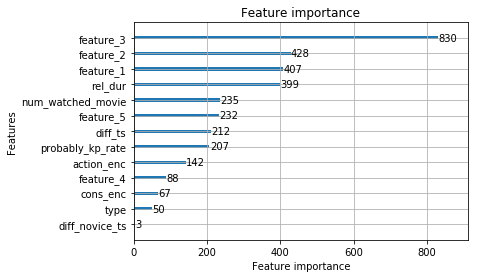

In [ ]:
lightgbm.plot_importance(model)

In [ ]:
other = data.loc[data.rating.isnull(),need_cols]
other['action_enc'] = other['action_enc'].map({'watch':1,'bookmate':2,'watch+rate':3,'watch+bookmate':4,
                                                    'rate':5,'watch+rate+bookmate':6,'rate+bookmate':7})
other['cons_enc'] = other['cons_enc'].map({'S':1,'P':2,'R':3,})

# lgb_other = lightgbm.Dataset(other,reference=lgb_dataset,categorical_feature=['feature_3','type','action_enc','cons_enc','is_history'],
#                               free_raw_data=False)

In [ ]:
pred = model.predict(other)

(array([  16647.,   21950.,   14243.,   35670.,   98691.,  285256.,
         376644.,  828301., 2143470., 6143662.]),
 array([-0.4569778 , -0.31856981, -0.18016182, -0.04175383,  0.09665416,
         0.23506215,  0.37347014,  0.51187813,  0.65028613,  0.78869412,
         0.92710211]),
 <a list of 10 Patch objects>)

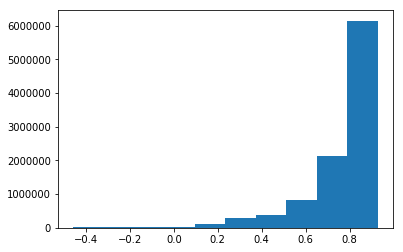

In [ ]:
plt.hist(pred - (1-pred))

In [ ]:
uv = pred - (1-pred)
uv_med = np.median(uv)

In [ ]:
uv_med

0.8166581423180199

In [ ]:
# Всем, у кого уверенность больше медианы - добавим 1 и -1 а потом сунем в предикты
data.loc[other[(uv>uv_med) & (pred>0.5)].index,'target_new'] = 1
data.loc[other[(uv>uv_med) & (pred<=0.5)].index,'target_new'] = -1
data.loc[data.rating>4,'target_new'] = 1
data.loc[data.rating<=4,'target_new'] = -1

In [ ]:
data.target_new.value_counts(normalize = True)

 1.0    0.99378
-1.0    0.00622
Name: target_new, dtype: float64

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

import implicit
import lightfm
import warnings
from validation_prepare import *
warnings.filterwarnings('ignore')

C:\Users\yabom\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [ ]:
data_m  = data.copy()#loc[data['target_new'].isnull()]

In [ ]:
data_m.set_index('first_ts',append=True,inplace=True)

In [ ]:
data_m.sort_index(inplace = True)

In [ ]:
idx = get_train_test(data_m)

6193642
2064548
2064547


In [ ]:
train,test,valid = data_m.iloc[idx[0]],data_m.iloc[idx[1]],data_m.iloc[idx[2]]

In [ ]:
np.min(train.target_new)

-1.0

In [ ]:
train.index = train.index.droplevel(-1)
test.index = test.index.droplevel(-1)
valid.index = valid.index.droplevel(-1)

In [ ]:
fe = FeatureExtractor({'movie_attr_matrix':element_matrix,'movie_match_columns':movie_match_columns,
                       'movie_columns_match':movie_columns_match,'movie_match_row_movie':match_row_element,
                      'movie_match_movie_row':match_element_row,},bag_of_attr,is_censor =False,delimiter=4,mode = 'not_null',
                      is_filtered=True,is_filtered_action=False,
                     target_col_name='target_new')

fe.fit(train)

100%|█████████████████████████████████████████████████████████████████████████| 391191/391191 [08:40<00:00, 751.26it/s]


(391191, 32474) 391191 32474


In [ ]:
train_ = fe.transform(train)
test_ = fe.transform(test)
valid_ = fe.transform(valid)

train_.shape,test_.shape 

cfe = ColdFeatureExtractor(fe)

cfe.fit(train)

max(cfe.train_movie_cols)

# sp.csc_matrix(cfe.fitted_FE.movie_attr_matrix)[cfe.train_movie_rows,cfe.train_movie_cols]



train_res = cfe.transform(test)


print(train_res['train_user'].shape,train_res['test_user'].shape,train_res['new_test_user'].shape)

print(train_res['train_movie'].shape,train_res['test_movie'].shape)

9275 391191
(3287610, 1) (3287610, 3)
(391191, 9275)
9275 391191
(1079790, 1) (804739, 3)
(391191, 9275)
9275 391191
(1053590, 1) (631112, 3)
(391191, 9275)


100%|█████████████████████████████████████████████████████████████████████████| 227612/227612 [05:28<00:00, 693.33it/s]


(391191, 32474) (391191, 32474) (55538, 32474)
(9275, 32485) (109, 32485)


In [ ]:
np.min(train_)

-1.0

In [ ]:
%%time
from collections import defaultdict
a,b = train_.nonzero()
D_row_col_train = defaultdict(set)
D_user_movie_train = defaultdict(set)
for i,ii in tqdm.tqdm(zip(a,b),total = len(a)):
    D_row_col_train[i].add(ii)
    D_user_movie_train[fe.match_row_user[i]].add(fe.train_movie_match_row_movie[ii])


a,b = test_.nonzero()
D_row_col_test = defaultdict(set)
D_user_movie_test = defaultdict(set)
for i,ii in tqdm.tqdm(zip(a,b),total = len(a)):
    D_row_col_test[i].add(ii)
    D_user_movie_test[fe.match_row_user[i]].add(fe.train_movie_match_row_movie[ii])


a,b = valid_.nonzero()
D_row_col_valid = defaultdict(set)
D_user_movie_valid = defaultdict(set)
for i,ii in tqdm.tqdm(zip(a,b),total = len(a)):
    D_row_col_valid[i].add(ii)
    D_user_movie_valid[fe.match_row_user[i]].add(fe.train_movie_match_row_movie[ii])

100%|██████████████████████████████████████████████████████████████████████| 631112/631112 [00:04<00:00, 155908.30it/s]


Wall time: 27.3 s


In [ ]:
seed = 0
epochs = 30
num_threads=4

model = lightfm.LightFM(loss = 'warp',random_state=seed)

In [ ]:
model.fit(train_,epochs = epochs)

In [ ]:
res = get_recomend(model,train_,fe,D_user_movie_train.keys(),D_row_col_train,mode = 'lightfm',is_filter_history=False)

metric(D_user_movie_train,res)

  8%|██████                                                                    | 30532/373915 [01:50<23:57, 238.81it/s]

In [ ]:
res = get_recomend(model,train_,fe,D_user_movie_test.keys(),D_row_col_train,mode = 'lightfm')

metric(D_user_movie_test,res)

In [ ]:
res = get_recomend(model,train_,fe,D_user_movie_valid.keys(),D_row_col_train,mode = 'lightfm')

metric(D_user_movie_valid,res)